# Genetrator of Halpha & 21cm snapshots to be fed to SKIRT and subsequent analysis of the SKIRT oputput
For the Halpha, it creates 3D snapshot of emissivity + Dust distribution to scatter it upon with SKIRT
For the 21cm, since the photodissociation of H2 is simulated in TIGRESS, it creates the centimetric radio flux maps.

# Importing the snapshots

In [1]:
# Importing the paths of the first snapshot of the simulation
# Importing the snapshot class and the units

import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from matplotlib.colors import LogNorm

basedir = '/export/home/extragal/lucia.armillotta/TIGRESS/R8'
output_dir_Halpha = '/export/home/extragal/francesco.chititegli/TIGRESS_1/Halfa/'
output_dir_HI = '/export/home/extragal/francesco.chititegli/TIGRESS_1/H21maps/'
snapshot_number = 0

s = pa.LoadSim(basedir, verbose=False)
ds = s.load_vtk(num=s.nums[snapshot_number])
u = s.u

[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 8834
[FindFiles-WARNING] rst files in out_fmt but not found.
/export/home/extragal/lucia.armillotta/.conda/envs/pyathena/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [2]:
# Lenghts are already in pc, Velocities are already in km/s, Temperatures are already be in K
# Gas cells' mass densities are already in g/cm3, and numeric densities are already in 1/cm3

time_cf = (u.time).to(units.Gyr).value
mass_cf = (s.u.mass).to(units.M_sun).value
density_cf = (s.u.density).to(units.M_sun / units.pc**3).value
number_density_cf = (units.cm**-3).to(units.pc**-3)
solar_metallicity = 0.0134
dust_to_gas_ratio = 0.01
h_alpha_wave = 0.65628 # (micron)
h_alpha_energy = 3.03e-12 # (erg)
H_mass = 8.41e-58 # (Msun)
H_mass_grams = 1.67e-24 # (grams)

print(s.basedir)
print(s.basename)
print(s.problem_id)
Nx = ds.domain['Nx']

# Printing the domain borders and cuboid cells grid

dx = ds.domain['dx']
volume = dx[0] * dx[1] * dx[2]
s.domain

/export/home/extragal/lucia.armillotta/TIGRESS/R8
R8
R8_4pc_NCR


{'all_grid_equal': True,
 'ngrid': 768,
 'le': array([ -512.,  -512., -3072.], dtype=float32),
 're': array([ 512.,  512., 3072.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 6144.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([ 256,  256, 1536]),
 'ndim': 3,
 'time': 200.0007}

In [3]:
# Cells borders (pc)
xmin = ds.domain['le'][0] + dx[0] * np.arange(Nx[0])
ymin = ds.domain['le'][1] + dx[1] * np.arange(Nx[1])
zmin = ds.domain['le'][2] + dx[2] * np.arange(Nx[2])
xmax = xmin + dx[0]
ymax = ymin + dx[1]
zmax = zmin + dx[2]

# Cells velocities (km/s)
velocities_x = ds.get_field('vx')
velocities_y = ds.get_field('vy')
velocities_z = ds.get_field('vz')

electron_density = ds.get_field('ne')  # Electrons Densities DERIVED FIELDS (1/cm3) -> (1/pc3) number_density_cf
temperature = ds.get_field('T')  # Temperatures (K)
gas_density = ds.get_field('rho')  # Gas density (g/cm3) -> (Msun/pc3) density_cf
HI_num_density = ds.get_field('nHI') # Neutral Hydrogen NUMBER density (1/cm3) -> (1/pc3) number_density_cf
H2_num_density = ds.get_field('nH2') # Molecular Hydrogen NUMBER density (1/cm3) -> (1/pc3) number_density_cf
hydrogen_fraction = ds.get_field('xHI') # Neutral hydrogen fraction

In [4]:
# Star particles
sp = s.load_starpar_vtk(num=s.nums_starpar[snapshot_number])

positions_stars_unmasked = np.array(sp[['x1', 'x2', 'x3']]) # Postions (pc)
velocities_stars_unmasked = np.array(sp[['v1', 'v2', 'v3']])  # Velocities (km/s)
mass_stars_unmasked = np.array(sp['mass'])  # Mass (Msun) -> (Msun) mass_cf
age_stars_unmasked = np.array(sp['age']) # Age (s) -> (Gyr) time_cf
smoothing_length_stars_unmasked = np.full_like(mass_stars_unmasked, 4.) # Smoothing Lenght (4 pc) defaulted as the cells' edge
metallicities_umasked = np.full_like(mass_stars_unmasked, solar_metallicity) # Metallicity (Zsun) defaulted as the metallicity of the Sun

print('Min non-zero age: ' + str(np.min(age_stars_unmasked[age_stars_unmasked > 0])))
print('Min non-zero mass: ' + str(np.min(mass_stars_unmasked[mass_stars_unmasked > 0])))

# Some of them have negative age, or null mass, so we mask them out
stars_mask = (mass_stars_unmasked > 0) & (age_stars_unmasked > 0)
positions_stars = positions_stars_unmasked[stars_mask]
velocities_stars = velocities_stars_unmasked[stars_mask]
mass_stars = mass_stars_unmasked[stars_mask]
age_stars = age_stars_unmasked[stars_mask]
smoothing_length_stars = smoothing_length_stars_unmasked[stars_mask]
metallicities = metallicities_umasked[stars_mask]

print('Pre-mask shape: ' + str(positions_stars_unmasked.shape) + ' VS Post-mask shape: ' + str(positions_stars.shape))
print('Post-mask mass range [Msun]: ' + str(mass_stars.min() * mass_cf) + ' to ' + str(mass_stars.max() * mass_cf))
print('Post-mask age range [Gyr]: ' + str(age_stars.min() * time_cf) + ' to ' + str(age_stars.max() * time_cf))
print('Post-mask metal range [1]: ' + str(metallicities.min()) + ' to ' + str(metallicities.max()))

Min non-zero age: 0.4214305579662323
Min non-zero mass: 5463.05859375
Pre-mask shape: (269, 3) VS Post-mask shape: (122, 3)
Post-mask mass range [Msun]: 189.15561998383632 to 155988.6788593846
Post-mask age range [Gyr]: 0.00041207152155797695 to 0.2343650207318719
Post-mask metal range [1]: 0.0134 to 0.0134


# Taking a slice of the snapshot and checking Halpha Surface Brightness

In [5]:
# RIDOTTO: we only take a thin slice of 256 pc
# For the first implementation of the full code, in order to test it as a whole, I only consider a slice of 256 pc
# centered on the galactic plane. With this we'll miss a big part of the less dense gas outside, but I will later modify it to import the full snapshot.
# (-256 < x3 < 256 /// 704 < Nx[3] < 832) YES

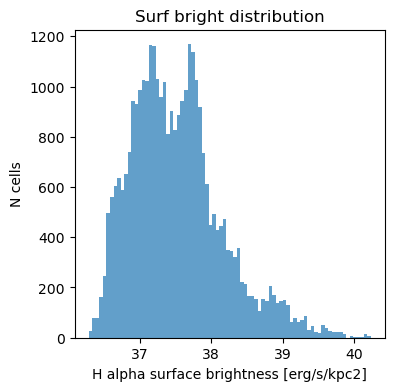

In [6]:
# To compute the Halpha luminosity, I used the formula (14.5) by Bruce Draine (2011), page 141.

# To have a first preliminary comparison with PHANGS, the Surface Brightness Distribution of Halpha is in agreement with the one shown in Fig.2
# of Belfiore et. al. (2021) "A tale of two DIGs". The distibuiton is compatible with the faintest ones by the Diffuse Ionized Gas.

fig, ax = plt.subplots(figsize=(4, 4))
raw = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4)**(-0.942-0.030*np.log((temperature['T'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128) / 1e4))) * (((electron_density['ne'].data.transpose(2, 1, 0)[:,:,704:832]).reshape(256, 256, 128))**2 * number_density_cf * 4. *1e6)
plot_data = np.sum(raw.transpose(2, 1, 0), axis=-1).transpose()
plt.hist(np.log10(plot_data.flatten()), bins=80, alpha=0.7)
plt.title('Surf bright distribution')
plt.ylabel('N cells')
plt.xlabel('H alpha surface brightness [erg/s/kpc2]')
plt.show()

# Creating arrays to export

In [7]:
# I computed the 21cm luminosity with a first-order approximation by employing the formula (8.3)
# by Bruce Draine (2011), page 71.
print('The pre-factor is: ' + str((3/4) * 2.8843e-15 * 6.62e-27 * 3.0e8 / 21e-2))

The pre-factor is: 2.0457927857142857e-32


In [8]:
# I arrange the data in several arrays: the spatial indexed distribution of the gas (Halfa_array) and its Halpha emission (SED_array); 
# the dust distribution (dust_array) for which I considered a solar neighbourhood D/G ratio; the hydrogen distribution (hydrogen_array)
# and its 21cm emission (HI_emission_array).
# The next step will be to import the velocities of the gas cells.

# Since SKIRT samples photons from SEDs, I had to index the cells and the luminosities.

Halfa_array = []
SED_array = []

dust_array = []

hydrogen_array =  []
HI_emission_array = []

ID_number = 0

for i in range(Nx[0]):
    for j in range(Nx[1]):
        for k in range(704, 832):
            xmin_val = xmin[i]
            ymin_val = ymin[j]
            zmin_val = zmin[k]
            xmax_val = xmax[i]
            ymax_val = ymax[j]
            zmax_val = zmax[k]
            
            dust_density_val = (gas_density['rho'].data)[k, j, i].astype(np.float64) * dust_to_gas_ratio
            temperature_val = (temperature['T'].data)[k, j, i].astype(np.float64)
            HI_ndens_val = (HI_num_density['nHI'].data)[k, j, i].astype(np.float64)
            H2_ndens_val = (H2_num_density['nH2'].data)[k, j, i].astype(np.float64)
            metallicities_val = solar_metallicity * 0.03

            ne2 = (electron_density['ne'].data)[k, j, i].astype(np.float64)
            T_4 = (temperature['T'].data)[k, j, i].astype(np.float64) / 1e4
            h_alpha_luminosity_val = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (T_4**(-0.942-0.030*np.log(T_4))) * (ne2**2 * number_density_cf * volume)

            hydrogen_density_val = (HI_ndens_val + H2_ndens_val * 2) * H_mass_grams
            H_surf_val = hydrogen_density_val * (units.g).to(units.M_sun) * number_density_cf * 4.0

            HI_prefattore = (3/4) * 2.8843e-15 * 6.62e-27 * 3.0e8 / 21e-2
            HI_lum_val = HI_prefattore * HI_ndens_val * number_density_cf * volume

            Halfa_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, ID_number, dust_density_val])
            SED_array.append([h_alpha_wave, h_alpha_luminosity_val])
            dust_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, dust_density_val, temperature_val])          
            hydrogen_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, hydrogen_density_val, metallicities_val, temperature_val, H_surf_val])
            HI_emission_array.append([HI_lum_val])

            ID_number = ID_number + 1

Halfa_array = np.array(Halfa_array)
SED_array = np.array(SED_array)
dust_array = np.array(dust_array)
hydrogen_array = np.array(hydrogen_array)
HI_emission_array = np.array(HI_emission_array)

print("Final ID_Number: " + str(ID_number))
del ID_number

Final ID_Number: 8388608


# Sanity check & HI maps

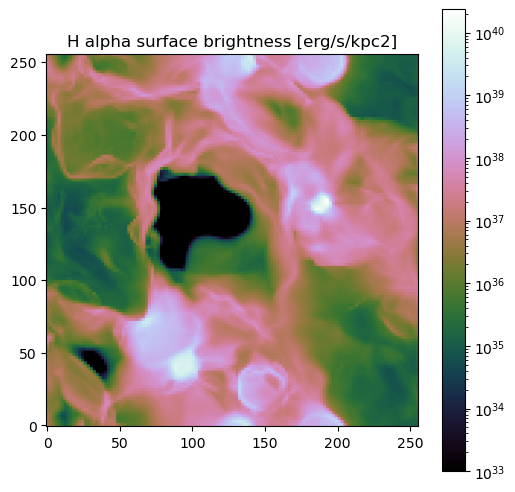

Dynamical range 29.37290230637849 to 40.37469499789299
Actual range 37 to 41


In [23]:
# I plot the surface brightness distribution of the Halpha

fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.sum(SED_array[:,1].reshape(256, 256, 128), axis=-1).transpose()
plot_data = plot_data / (4. * 4. * 1e-6)
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e33, vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('H alpha surface brightness [erg/s/kpc2]')
plt.show()
print('Dynamical range ' + str(np.log10(plot_data.min())) + ' to ' + str(np.log10(plot_data.max())) )
print('Actual range ' + str(37) + ' to ' + str(41) )

In [9]:
# Since the averages of some physical quantities are needed for SKIRT, I print them

print('Default metallicity of the gas: ' + str(np.mean(hydrogen_array[:,7])))
print('Average temperature of the gas: ' + str(np.mean(hydrogen_array[:,8])) + ' K')
print('Average Sur Mass Dens of the gas: ' + str(np.mean(hydrogen_array[:,9])) + ' Msun/pc3')

# In order to convert from/to (erg/s) to/from (MJy/sr) I create this conversion factor
prefattore = 1e23 * 1e8 * 1e-6 / (4*np.pi* (3.086e25)**2) # (erg/s) -> (MJy/sr) conversion
print('The conversion factor from (erg/s) to (MJy/sr) (prefattore) is ' + str(prefattore) + ' MJy * s/erg * sr')

Default metallicity of the gas: 0.00040200000000000923
Average temperature of the gas: 499558.7957791797 K
Average Sur Mass Dens of the gas: 0.03778798816797816 Msun/pc3
The conversion factor from (erg/s) to (MJy/sr) (prefattore) is 8.355997329728561e-28 MJy * s/erg * sr


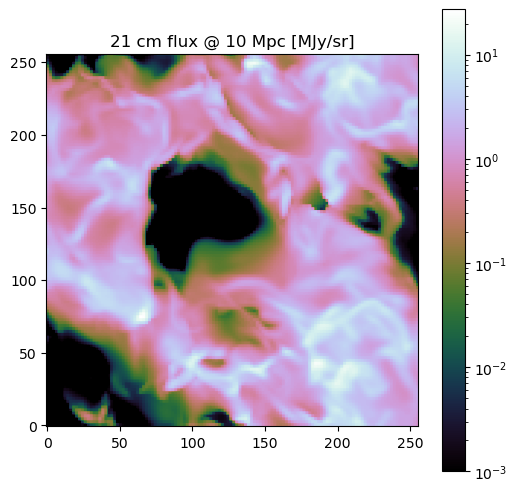

Dynamical range -10.897604187515192 to 1.4384171273116286


In [11]:
# I plot the flux of the 21 cm (for a distance of 10 Mpc).
# Since the photodissociation of H2 is already simulated in TIGRESS ISM, I do not need to process the HI map through SKIRT

fig, ax = plt.subplots(figsize=(6, 6))
plot_data = np.sum(HI_emission_array.reshape(256, 256, 128), axis=-1).transpose()
plot_data = plot_data * prefattore
im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e-3, vmax=plot_data.max()))
plt.colorbar(im, ax=ax)
ax.set_title('21 cm flux @ 10 Mpc [MJy/sr]')
plt.show()
print('Dynamical range ' + str(np.log10(plot_data.min())) + ' to ' + str(np.log10(plot_data.max())) )

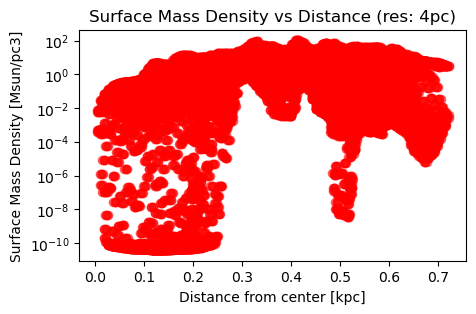

In [12]:
# The second preliminary comparison with PHANGS is for the 21 cm line emission, rather than for the Halpha.
# I wanted to compare the surface mass density of the snapshot slice with the ones in Eibensteiner et al. (2024)
# "PHANGS-MeerKAT and MHONGOOSE HI observations".
# I recall that SKIRT takes as input the surface mass density of HI + H2, so I expect my results to be an overestimate.
# The distances in the plot will of course not be galactocentric, but from the center of the snapshot, so are just meant
# to distinguish the cells. Nevertheless, the snapshot is simulated in the solar neighbourhood, so I expect
# it to be compatible with the first 5-8 kpc of the plots in Eibensteiner et al. (2024).

gal_distance = 1e-3 * np.sqrt( ((hydrogen_array[:,0] + hydrogen_array[:,3]) / 2)**2 + ((hydrogen_array[:,1] + hydrogen_array[:,4]) / 2)**2 )
gal_distance = gal_distance.reshape(256, 256, 128)[...,0].transpose()
gas_surf = np.sum(hydrogen_array[:,9].reshape(256, 256, 128), axis=-1).transpose()

plt.figure(figsize=(5, 3))
plt.scatter(gal_distance, gas_surf, c='red', alpha=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Distance from center [kpc]')
plt.ylabel('Surface Mass Density [Msun/pc3]')
plt.title('Surface Mass Density vs Distance (res: 4pc)')
plt.show()

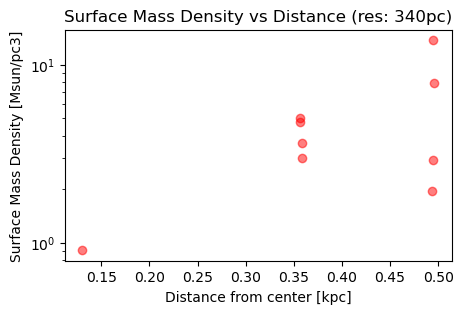

In [13]:
# The large drop on the left side of the plot is given by the big void in the center of the snapshot. In the TIGRESS
# ISM simulation, the cells have a spacial resolution of 4 pc, thus I need to rebin the plot so to sample it with a
# realistic resolution. Since the face-on snapshot is 1024x1024pc, I cannot sample it with coarser resolutions: in Table 2
# of Eibensteiner et al. (2024) the observation of NGC 5068 is indicated to have a beam size of 0.34 kpc, so I choose that
# as a possible observational resolution (leading to a 3x3 pixel rebinned plot). 
# The resulting Surface Mass Density of HI + H2 is compatible with Panel 4 of Figure 7 of Eibensteiner et al. (2024).
# However, the images and plots of the paper are all made so to have a resolution around 15", that is 1500pc circa.

def process_arrays(distan, densit, macro_size=(85, 85, 86)):
    result_dist = np.zeros((3, 3))
    result_dens = np.zeros((3, 3))
    
    for i in range(3):
        for j in range(3):
            row_start = i * macro_size[i] if i < 2 else (i * macro_size[i])
            row_end = (i + 1) * macro_size[i] if i < 2 else 256
            col_start = j * macro_size[j] if j < 2 else (j * macro_size[j])
            col_end = (j + 1) * macro_size[j] if j < 2 else 256

            result_dist[i, j] = np.mean(distan[row_start:row_end, col_start:col_end])
            result_dens[i, j] = np.mean(densit[row_start:row_end, col_start:col_end])
    
    return result_dist, result_dens

plt.figure(figsize=(5, 3))
plt.scatter(process_arrays(gal_distance, gas_surf)[0], process_arrays(gal_distance, gas_surf)[1], c='red', alpha=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Distance from center [kpc]')
plt.ylabel('Surface Mass Density [Msun/pc3]')
plt.title('Surface Mass Density vs Distance (res: 340pc)')
plt.show()

# Saving the data

In [ ]:
# Now I save the arrays in .txt file (the next step will be to save them as .scol, which is the only other format
# that SKIRT can import sources and medium).

header = """# Halfa_Ridotto.txt: import file for cell source -- Halfa
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: index (1)
# Column 8: mass density (g/cm3)
#
"""
with open(f"{output_dir_Halpha}Halfa_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, Halfa_array, fmt="%g")

#######################################################################################################################

header = """# Dust_Ridotto.txt: import file for cell media -- dust
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: temperature (K)
#
"""
with open(f"{output_dir_Halpha}Dust_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, dust_array, fmt="%g")

########################################################################################################################

header = """# Hydrogen_21_Ridotto.txt: import file for cell media -- gas
# Column 1: xmin (pc)
# Column 2: ymin (pc)
# Column 3: zmin (pc)
# Column 4: xmax (pc)
# Column 5: ymax (pc)
# Column 6: zmax (pc)
# Column 7: mass density (g/cm3)
# Column 8: metallicity (1)
# Column 9: temperature (K)
# Column 10: surface mass density (Msun/pc2)
#
"""
with open(f"{output_dir_HI}Hydrogen_21_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, hydrogen_array, fmt="%g")

header = """# Stars_21_Ridotto.txt: import file for particle source 
# Column 1: position x (pc)
# Column 2: position y (pc)
# Column 3: position z (pc)
# Column 4: smoothing length (pc)
# Column 5: mass (Msun)
# Column 6: metallicity (1)
# Column 7: age (Gyr)
#
"""
with open(f"{output_dir_HI}Stars_21_Ridotto.txt", "w") as txt_file:
    txt_file.write(header)
    np.savetxt(txt_file, stars_array, fmt="%g")

In [ ]:
# The indexed SEDs are saved as .stab as it is the only format that SKIRT likes to import SEDs
# Furthermore, it is needed to convert from erg/s a watt

from pts.storedtable.io import writeStoredTable
def convertMonochromaticSimulation(wavelengths, luminosities, outFilePath):
    erg_to_watt = 1e-7
    luminosities_per_micron = luminosities * erg_to_watt
    w = np.array([0.656, 0.657])
    print(w)

    ID = np.arange(len(luminosities))
    print(ID.shape)
    
    L = np.zeros((len(w), len(luminosities)))
    L[0, :] = luminosities * 1e3
    L[1, :] = luminosities * 1e3
    print(L.shape)
    print(L)

    writeStoredTable(outFilePath,['lambda', 'index'], ['m', '1'], ['lin', 'lin'],[w*1e-6, ID],['Llambda'], ['W/m'], ['lin'], [L*1e6])
    
convertMonochromaticSimulation(SED_array[:,0],SED_array[:,1],f"{output_dir_Halpha}SEDfamily_Ridotto.stab")

In [30]:
from pts.storedtable.io import readStoredTable
readStoredTable(f"{output_dir_Halpha}SEDfamily_Ridotto.stab")

{'axisNames': ['lambda', 'index'],
 'axisUnits': ['m', '1'],
 'axisScales': ['lin', 'lin'],
 'quantityNames': ['Llambda'],
 'quantityUnits': ['W/m'],
 'quantityScales': ['lin'],
 'lambda': <Quantity [6.56e-07, 6.57e-07] m>,
 'index': <Quantity [0.000000e+00, 1.000000e+00, 2.000000e+00, ..., 8.388605e+06,
            8.388606e+06, 8.388607e+06]>,
 'Llambda': <Quantity [[6.89688020e+37, 6.89688020e+37, 6.07549038e+37, ...,
             1.62932931e+37, 1.57614671e+37, 1.57614671e+37],
            [6.89688020e+37, 6.89688020e+37, 6.07549038e+37, ...,
             1.62932931e+37, 1.57614671e+37, 1.57614671e+37]] W / m>}

# Halpha map

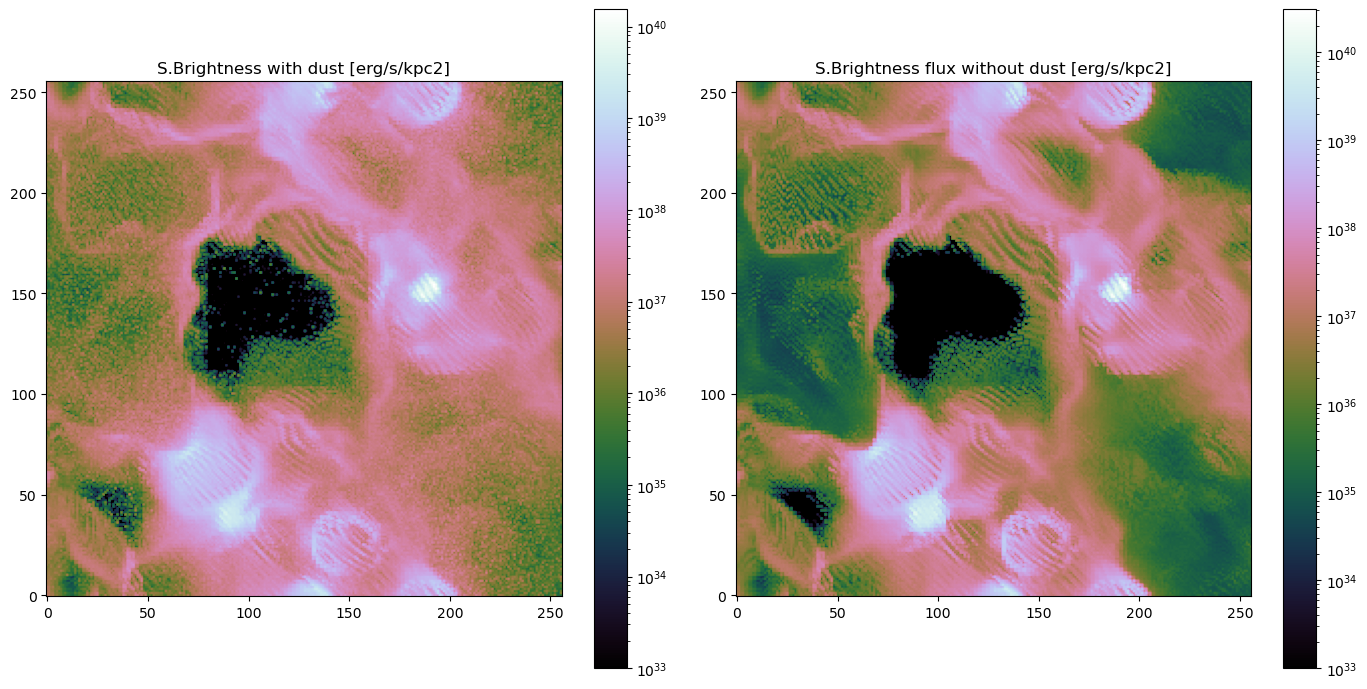

BUNIT with dust: MJy/sr
Range with dust: 1.565071869998433e+29 to 1.5532779018278624e+40
BUNIT without dust: MJy/sr
Range without dust: 1.5301063371919361e+29 to 3.094183133354338e+40


In [19]:
# Now that I exported all the input files for SKIRT, I write and run the SKIRT codes for the radiative transfer.
# The simulated system was placed at a distance of 10 Mpc from the detector.
# SKIRT returns datacubes measured as MJy/sr, so I had to multiply for the conversionf actor (prefattore) to get the luminosity
# and then divide for the cell surface to get the surface brightness.
# Here I visualize the dust extinction by plotting the Halpha flux with and without the dust, to then plot the extintion.

from astropy.io import fits
with fits.open(f"{output_dir_Halpha}HaTr2_i0_total.fits") as hdul:
    image_fits = hdul[0].data.astype(np.float64) / prefattore
    image_fits = image_fits / (16e-6)
    header = hdul[0].header
with fits.open(f"{output_dir_Halpha}HaTr_i0_nodust_total.fits") as hdul:
    image_fits_nodust = hdul[0].data.astype(np.float64) / prefattore
    image_fits_nodust = image_fits_nodust / (16e-6)
    header_nodust = hdul[0].header

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
im1 = axes[0].imshow(np.squeeze(image_fits), cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e33, vmax=image_fits.max()))
plt.colorbar(im1, ax=axes[0])
axes[0].set_title('S.Brightness with dust [erg/s/kpc2]')
im2 = axes[1].imshow(np.squeeze(image_fits_nodust), cmap='cubehelix', origin='lower', norm=LogNorm(vmin=1e33, vmax=image_fits_nodust.max()))
plt.colorbar(im2, ax=axes[1])
axes[1].set_title('S.Brightness flux without dust [erg/s/kpc2]')
plt.tight_layout()
plt.show()

print(f"BUNIT with dust: {header['BUNIT']}")
print('Range with dust: ' + str(image_fits.min()) + ' to ' + str(image_fits.max()))
print(f"BUNIT without dust: {header_nodust['BUNIT']}")
print('Range without dust: ' + str(image_fits_nodust.min()) + ' to ' + str(image_fits_nodust.max()))

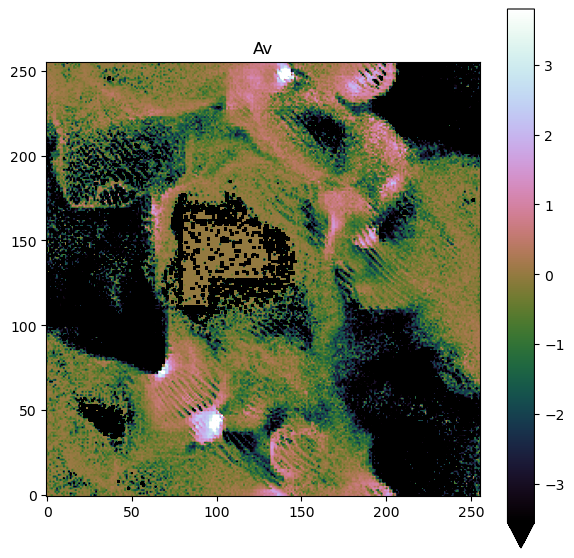

BUNIT: MJy/sr
Range: -9.77899803561627 to 10.444526993110628


In [22]:
# In this picture we can see the attenuation, represented as Av (Av =  -2.5 log(wdust / wodust)).
# This results in the attenutation in the dense regions and the double-scattering onto the line of sight that enhances the fainter regions.

image_fits_atten_nomasked = np.squeeze(image_fits) / np.squeeze(np.where(image_fits_nodust == 0, 0.00005801245, image_fits_nodust))
image_fits_atten = np.ma.masked_where(image_fits_atten_nomasked >= 50, image_fits_atten_nomasked)

image_fits_atten = - 2.5 * np.log(np.squeeze(image_fits_atten))

fig, ax = plt.subplots(figsize=(7, 7))
palette = plt.cm.cubehelix.with_extremes(bad='k')
im = ax.imshow(np.squeeze(image_fits_atten), cmap=palette, origin='lower', vmin=-3.555999, vmax=3.7980096)
plt.colorbar(im, ax=ax, extend='min')
ax.set_title('Av')
#plt.xlim(150,200)
#plt.ylim(130,180)
#plt.grid()
plt.show()

print(f"BUNIT: {header_nodust['BUNIT']}")
print('Range: ' + str(image_fits_atten.min()) + ' to ' + str(image_fits_atten.max()))

# ISM phases visualization

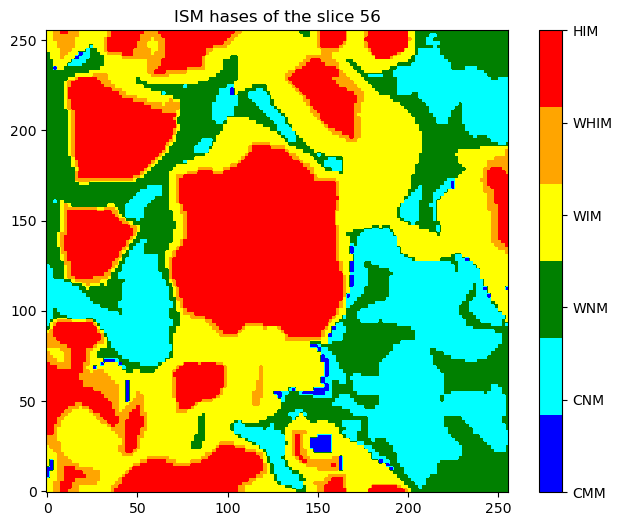

In [21]:
# I can also distinguish amongst the various phases of the ISM with a simple classification,
# which is partially taken from Kim et. al. (2023) "Introducing TIGRESS-NCR. I"
# Normally, I would not use this part of the code, so I did not include this in the main for cycle to create the snapshots to export to SKIRT.

phase_array = []
for i in range(Nx[0]):
    for j in range(Nx[1]):
        for k in range(704, 832):
            temperature_val = (temperature['T'].data)[k, j, i]
            HI_fraction_val = (hydrogen_fraction['xHI'].data)[k, j, i]

            if temperature_val > 5e5:
                cat_val = "HIM"
            elif 3.5e4 < temperature_val <= 5e5:
                cat_val = "WHIM"
            elif 6e3 < temperature_val <= 3.5e4:
                if HI_fraction_val < 0.5:
                    cat_val = "WIM"
                else:
                    cat_val = "WNM"
            elif temperature_val <= 6e3:
                if HI_fraction_val > 0.5:
                    cat_val = "CNM"
                else:
                    cat_val = "CMM"
            phase_array.append([cat_val, HI_fraction_val])
phase_array = np.array(phase_array)

from matplotlib.colors import ListedColormap
category_mapping = {"CMM": 0, "CNM": 1, "WNM": 2, "WIM": 3, "WHIM": 4, "HIM": 5}
colors = ["blue", "cyan", "green", "yellow", "orange", "red"]
cmap = ListedColormap(colors)

plot_phases = (phase_array[:,0].reshape(256, 256, 128))[:,:,56].transpose()

plt.figure(figsize=(8, 6))
plt.imshow(np.vectorize(category_mapping.get)(plot_phases) , cmap=cmap, origin="lower")
cbar = plt.colorbar(ticks=range(len(category_mapping)))
cbar.ax.set_yticklabels(category_mapping.keys())
plt.title("ISM hases of the slice " + str(56))
plt.show()
